# EDA

## ETH close price over time + Trading Volume

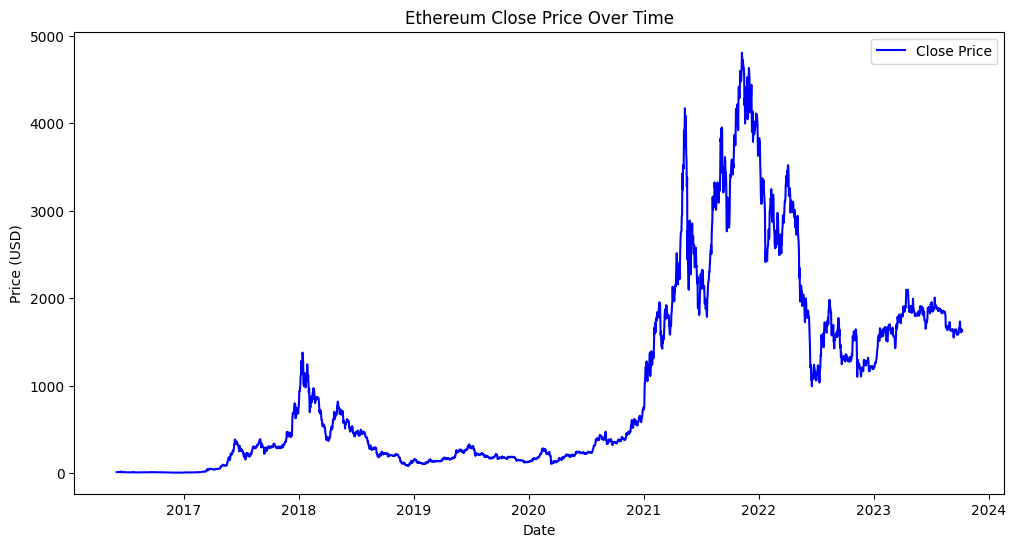

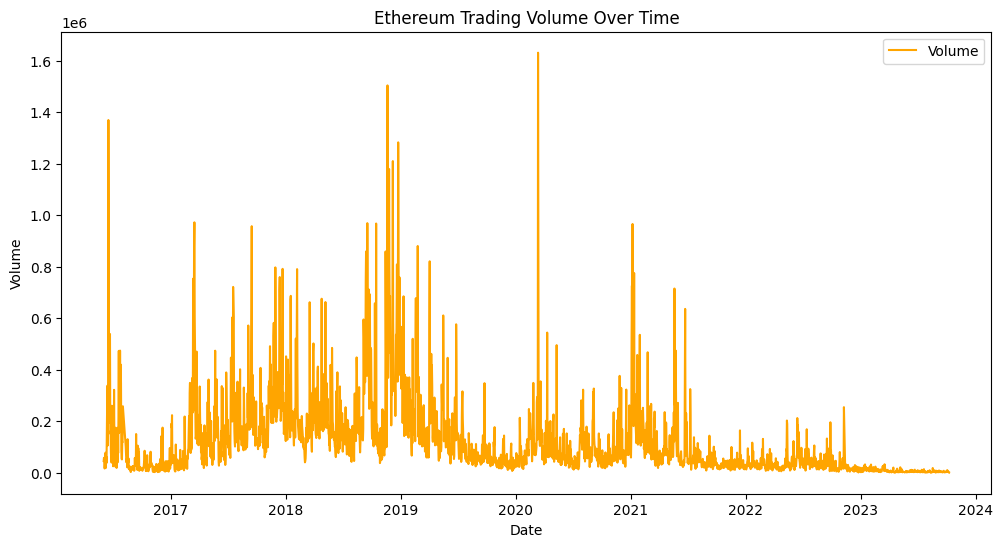

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('../../data/ethusd_group_project.csv')
df['time'] = pd.to_datetime(df['time'])
# Plot Close price
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['close'], label="Close Price", color='blue')
plt.title("Ethereum Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Plot Volume
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['volume'], label="Volume", color='orange')
plt.title("Ethereum Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()

## Daily Returns vs RV

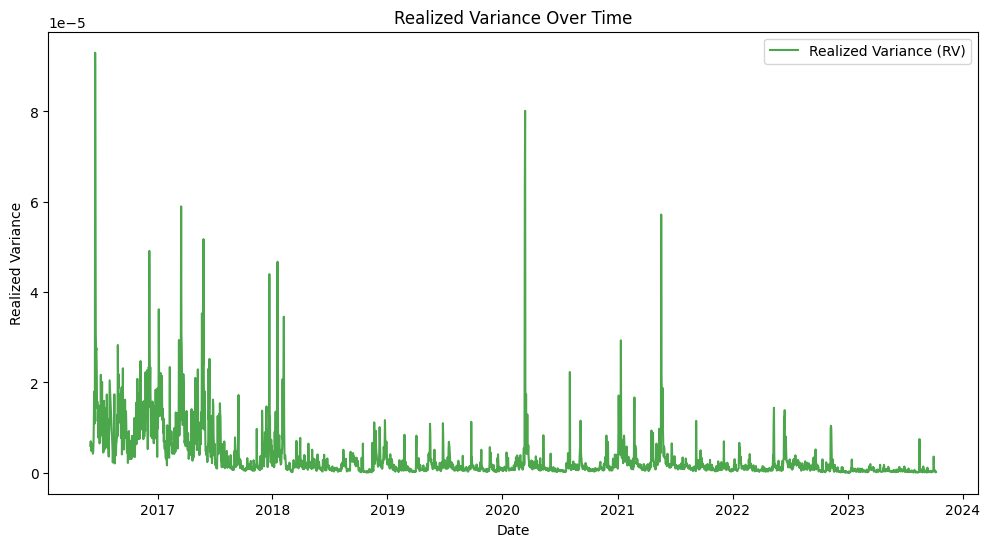

In [2]:
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['RV_d,t'], color='green', alpha=0.7, label="Realized Variance (RV)")
plt.xlabel("Date")
plt.ylabel("Realized Variance")
plt.title("Realized Variance Over Time")
plt.legend()
plt.show()


### RV Trends

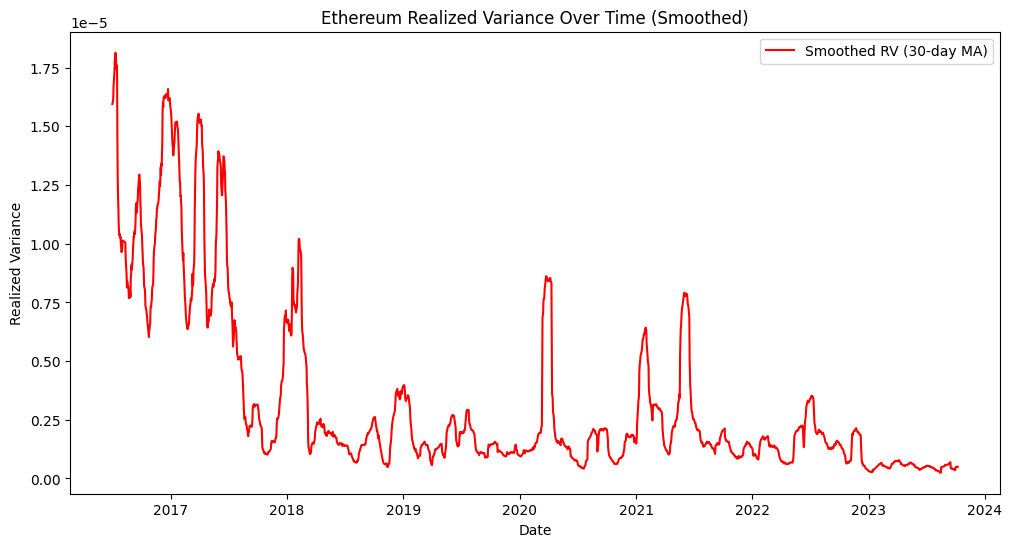

In [3]:
df['RV_smoothed'] = df['RV_d,t'].rolling(window=30).mean()
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['RV_smoothed'], color='red', label="Smoothed RV (30-day MA)")
plt.xlabel("Date")
plt.ylabel("Realized Variance")
plt.title("Ethereum Realized Variance Over Time (Smoothed)")
plt.legend()
plt.show()


In [4]:
correlation = df['daily_return'].corr(df['RV_d,t'])
print(f"Correlation between Daily Returns and Realized Variance: {correlation:.2f}")


Correlation between Daily Returns and Realized Variance: -0.09


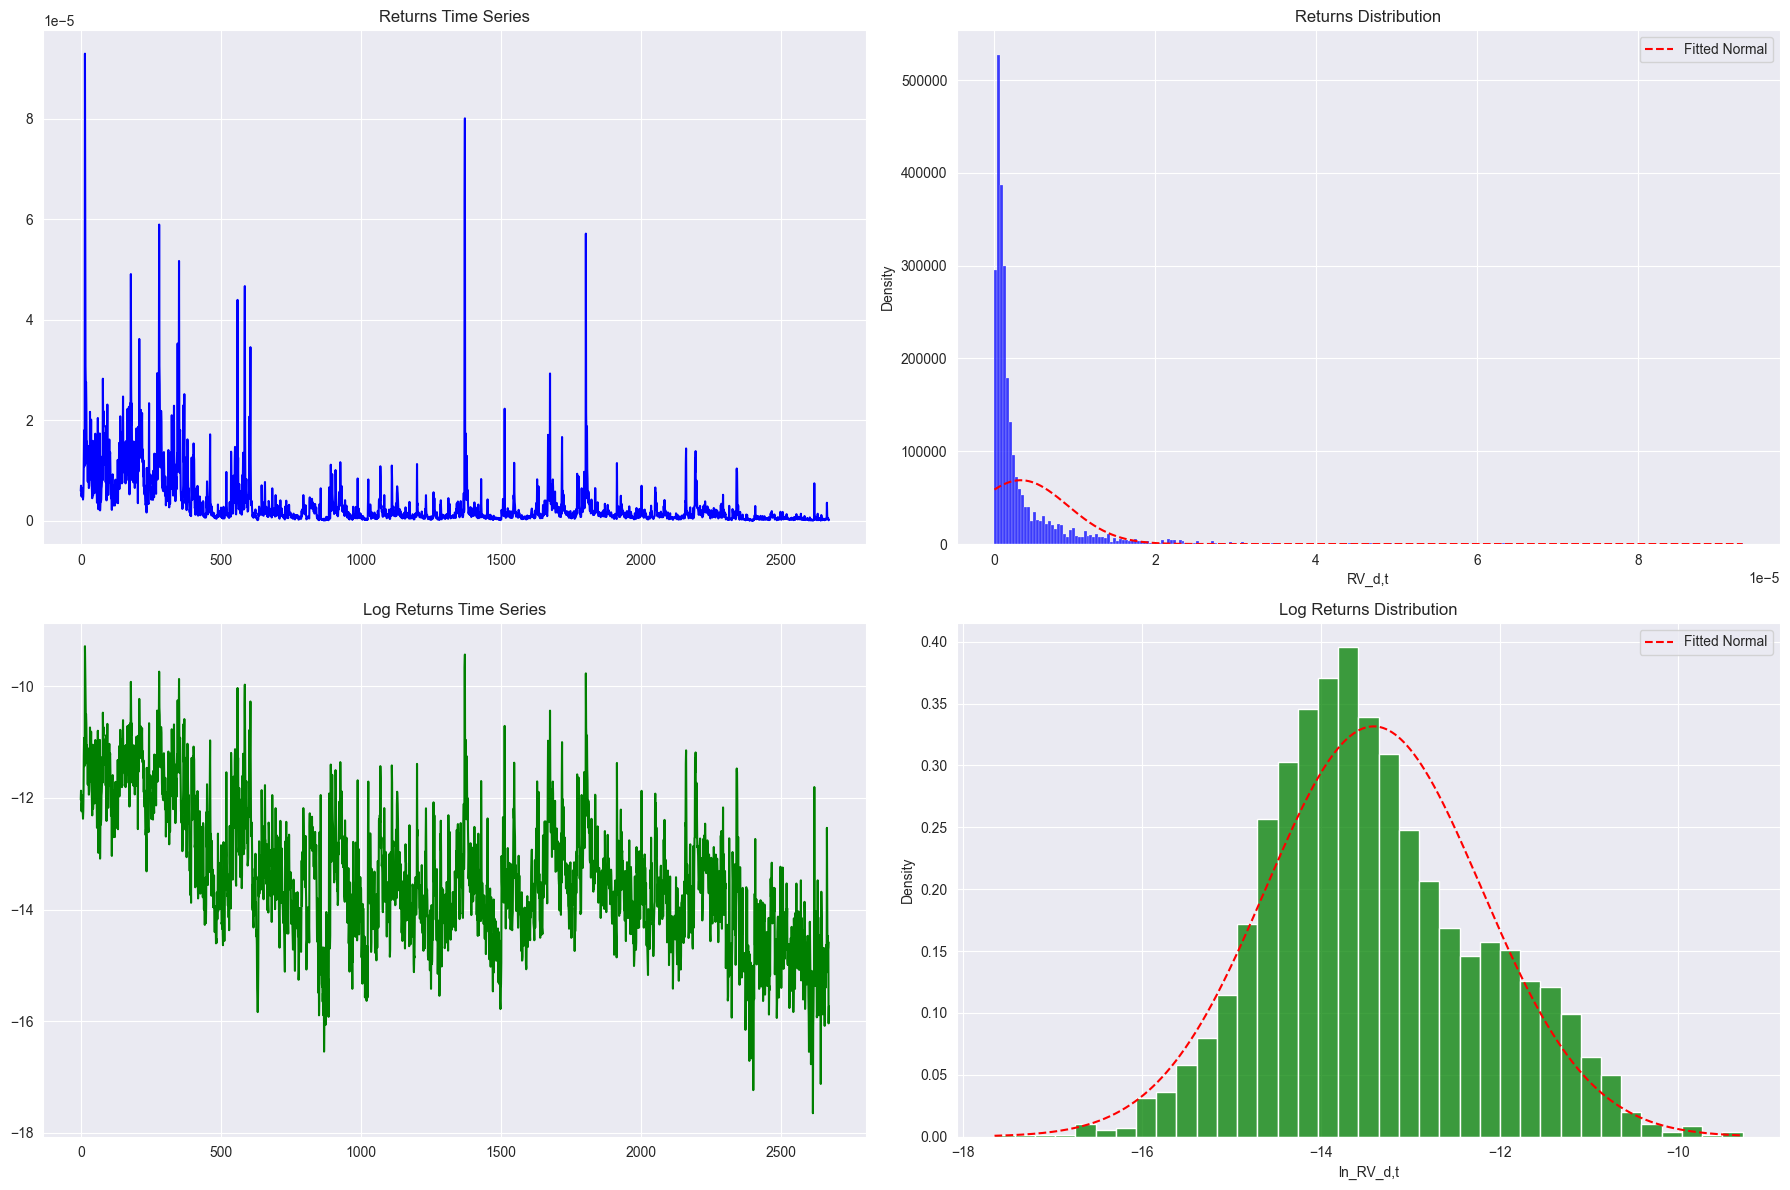

In [7]:
from scipy.stats import norm
import seaborn as sns

df_eda = df[['time', 'open', 'close', 'high', 'low', 'volume', 'RV_d,t', 'ln_RV_d,t']].copy()
df_eda.dropna(inplace=True)

# Create x ranges based on the data in each column.
x_returns = np.linspace(df_eda["RV_d,t"].min(), df_eda["RV_d,t"].max(), 1000)
x_log_returns = np.linspace(df_eda["ln_RV_d,t"].min(), df_eda["ln_RV_d,t"].max(), 1000)

with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

    axes[0, 0].plot(df_eda["RV_d,t"], color='blue')
    axes[0, 0].set_title('Returns Time Series')

    sns.histplot(data=df_eda, x="RV_d,t", color='blue', ax=axes[0, 1], stat='density')
    mu_ret = np.mean(df_eda["RV_d,t"])
    std_ret = np.std(df_eda["RV_d,t"])
    axes[0, 1].plot(x_returns, norm.pdf(x_returns, mu_ret, std_ret), 
                    color='red', linestyle='dashed', label='Fitted Normal')
    axes[0, 1].set_title('Returns Distribution')
    axes[0, 1].legend()

    axes[1, 0].plot(df_eda["ln_RV_d,t"], color='green')
    axes[1, 0].set_title('Log Returns Time Series')

    sns.histplot(data=df_eda, x="ln_RV_d,t", color='green', ax=axes[1, 1], stat='density')
    mu_log = np.mean(df_eda["ln_RV_d,t"])
    std_log = np.std(df_eda["ln_RV_d,t"])
    axes[1, 1].plot(x_log_returns, norm.pdf(x_log_returns, mu_log, std_log), 
                    color='red', linestyle='dashed', label='Fitted Normal')
    axes[1, 1].set_title('Log Returns Distribution')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()


## S&P500 vs ETH pricing (Scaled)

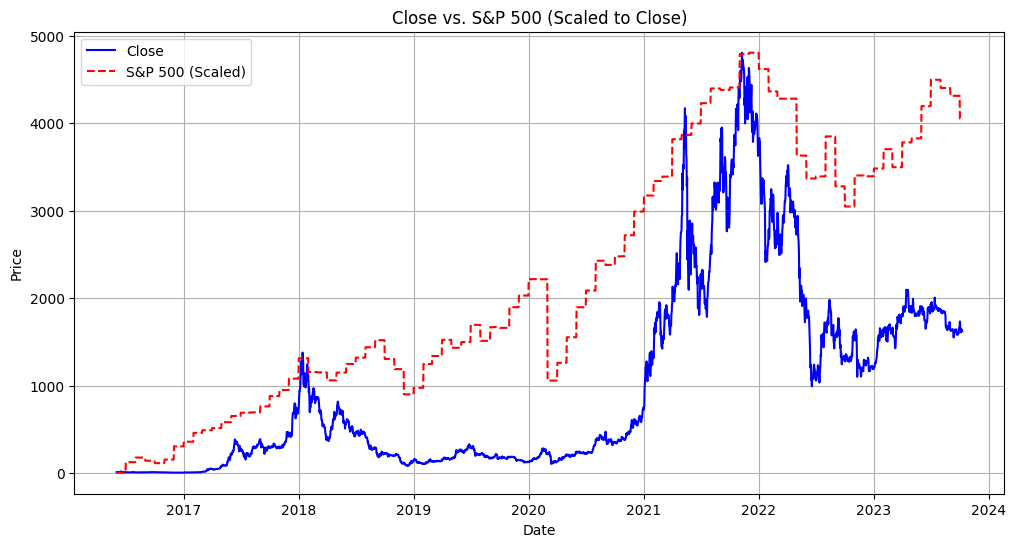

In [8]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler with the feature range set to the range of 'close'
scaler = MinMaxScaler(feature_range=(df['close'].min(), df['close'].max()))

# Fit and transform the "S&P 500" column
df['S&P 500_scaled'] = scaler.fit_transform(df[['S&P 500']])

# Plot both series on the same graph
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['close'], label='Close', color='blue')
plt.plot(df['time'], df['S&P 500_scaled'], label='S&P 500 (Scaled)', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Close vs. S&P 500 (Scaled to Close)")
plt.legend()
plt.grid(True)
plt.show()
